```{contents}
:local:
:depth: 2
```

# Metals in air masses and their effect on KD onset

## Preamble


### Imports

#### Python

In [1]:
%load_ext rpy2.ipython

In [60]:
import dabest

import numpy as np
import pandas as pd
import plotnine as p9

from collections import defaultdict
from matplotlib import pyplot as plt
from mizani.breaks import date_breaks
import statsmodels.formula.api as smf
from mizani.formatters import date_format
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

#### R

In [ ]:
%%R
library(dplyr)
library(ggplot2)

### Pre-sets

In [4]:
p9.options.set_option('dpi', 200)
p9.options.set_option('figure_size', (4, 3))
p9.options.set_option('base_family', 'Bitstream Vera Serif')
p9.theme_set(p9.theme_bw() + p9.theme(axis_text=p9.element_text(size=7),
                                      axis_title=p9.element_text(size=9)))

## Data Preprocessing

## Reading


In [9]:
raw_chem_df = pd.read_excel('../data/KD_chemistry_2011.xlsx', engine='openpyxl', sheet_name=0)

In [14]:
kd_df = (pd.read_excel('../data/KD_chemistry_2011.xlsx', engine='openpyxl', sheet_name=0)
         .iloc[72:80]
        )

### Cleaning


In [11]:
long_chemistry = (raw_chem_df
                 .iloc[1:71, :38]
                 .set_index('Filter')
                 .T
                 .reset_index()
                 .assign(date=lambda dd: pd.to_datetime(dd['index'], dayfirst=True))
                 .drop(columns=['index', np.NaN, 'ng/m3'])
                 .melt('date', var_name='compound', value_name='concentration')
                 .assign(concentration=lambda dd: dd.concentration.astype(float))
                 .assign(compound=lambda dd: dd['compound'].str.rstrip())
                 )

In [7]:
long_chemistry.head()

,date,compound,concentration
0,2011-03-22,PM10,39.650350
1,2011-03-23,PM10,22.937063
2,2011-03-24,PM10,36.391416
3,2011-03-25,PM10,27.501910
4,2011-03-26,PM10,28.251748


In [12]:
wide_chemistry = long_chemistry.pivot('date', 'compound', 'concentration')

In [15]:
kd_ts = (kd_df
         .set_index('Filter')
         .T
         .dropna()
         .reset_index(drop=True)
         .rename(columns={f'KD cases D{i}': f'kd_lag_{i}' for i in range(4)})
         .rename(columns={'KD cases D03': 'kd_rolling_4'})
         [['date'] + [f'kd_lag_{i}' for i in range(4)] + ['kd_rolling_4']]
         .assign(kd_rolling_4=lambda dd: dd.kd_rolling_4.astype(int))
)
kd_ts

Filter,date,kd_lag_0,kd_lag_1,kd_lag_2,kd_lag_3,kd_rolling_4
0,2011-03-22,1,0,0,2,3
1,2011-03-23,0,0,2,0,2
2,2011-03-24,0,2,0,0,2
3,2011-03-25,2,0,0,1,3
4,2011-03-26,0,0,1,1,2
5,2011-03-27,0,1,1,1,3
6,2011-03-28,1,1,1,2,5
7,2011-03-29,1,1,2,1,5
8,2011-03-30,1,2,1,0,4
9,2011-03-31,2,1,0,1,4


## Analysis

#### Preliminary view

Just visualizing the change in KD cases (on a 4 day rolling window from 0 to +3 days), the aggregated concentration of all metals, and the concentration of PM10 we can already see the high degree of synchrony between these three variables:


/tmp/ipykernel_187664/2022152195.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/afontal/.cache/pypoetry/virtualenvs/kd-metals-swc-La39c6PI-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


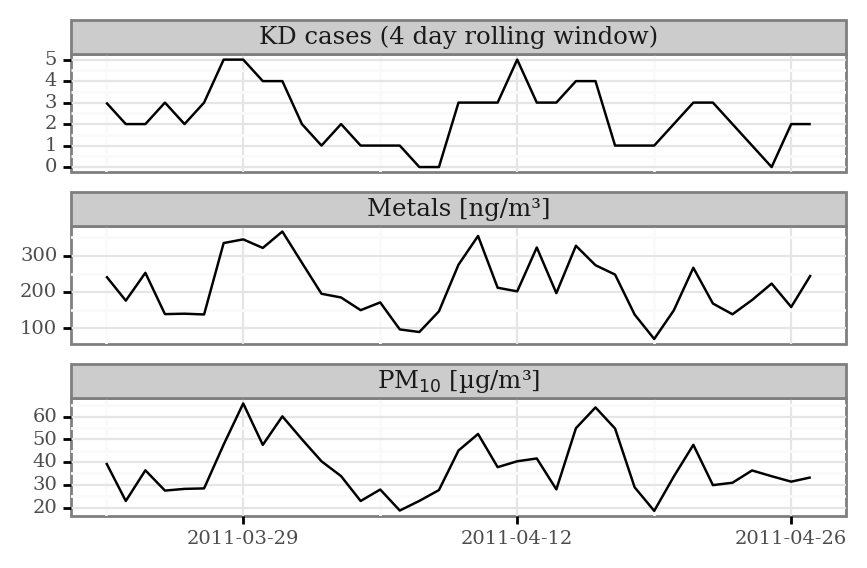

<ggplot: (8771536440290)>

In [57]:
(long_chemistry
 .loc[lambda dd: dd.compound.isin(['PM10', 'METALLS'])]
 .assign(group=lambda dd: np.where(dd.compound=='METALLS','Metals [ng/m³]', 'PM$_{10}$ [µg/m³]'))
 .append(kd_ts[['date', 'kd_rolling_4']]
         .assign(group='KD cases (4 day rolling window)')
         .rename(columns={'kd_rolling_4': 'concentration'}))
 .assign(concentration=lambda dd: dd.concentration.astype(float))
 .pipe(lambda dd: p9.ggplot(dd)
       + p9.aes('date', 'concentration')
         + p9.geom_line() 
         + p9.facet_wrap('group', ncol=1, scales='free_y')
         + p9.theme(figure_size=(5, 3))
         + p9.labs(x='', y='')
         + p9.scale_x_datetime(breaks=date_breaks('2 week'))
      )
)

#### Pairwise correlations


In [16]:
long_metals = (raw_chem_df
               .iloc[22:70, :38]
               .set_index('Filter')
               .T
               .reset_index()
               .assign(date=lambda dd: pd.to_datetime(dd['index'], dayfirst=True))
               .fillna(0)
               .drop(columns='index')
               .melt('date', var_name='compound', value_name='concentration')
               .assign(concentration=lambda dd: dd.concentration.astype(float))
               .assign(compound=lambda dd: dd['compound'].str.rstrip())
)

In [17]:
wide_metals = long_metals.pivot('date', 'compound', 'concentration')

In [18]:
pairwise_corrs = (wide_metals
                 .corr()
                 .reset_index()
                 .melt('compound', var_name='compound_b', value_name='r')
                 .loc[lambda dd: dd.compound <= dd.compound_b]
                 )

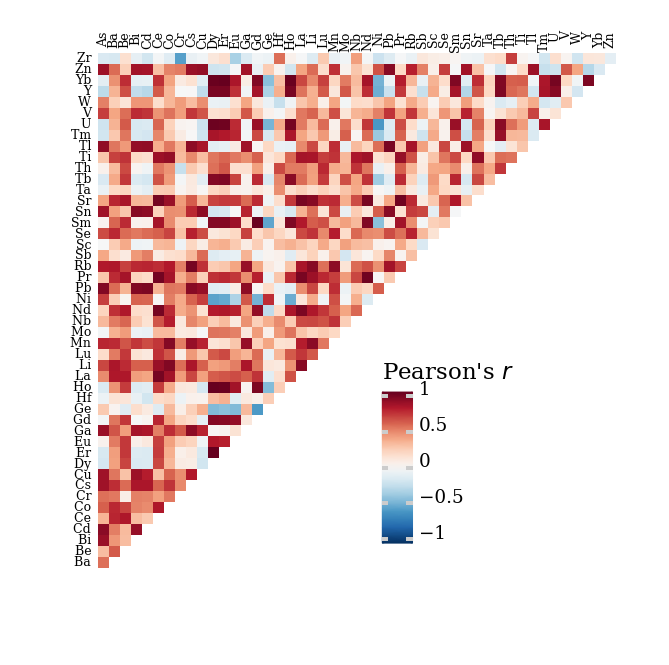

In [20]:
f = (pairwise_corrs
.loc[lambda dd: dd['compound']!=dd['compound_b']]
 .pipe(lambda dd: p9.ggplot(dd) 
       + p9.aes('compound', 'compound_b') 
       + p9.geom_tile(p9.aes(fill='r'))
       + p9.theme_classic()
       + p9.scale_fill_continuous('RdBu_r', limits=(-1, 1))
       + p9.theme(figure_size=(5.5, 5.5), dpi=150, axis_line=p9.element_blank(), axis_text=p9.element_blank(),
                  axis_ticks=p9.element_blank(), legend_position=(.65, .35), legend_key_size=10)
       + p9.labs(x='', y='', fill="Pearson's $r$")
       + p9.geom_text(p9.aes(label='compound', x='compound'), y=49.5, data=dd[['compound']].drop_duplicates(),
                      angle=90, va='top', ha='center', size=6)
        + p9.geom_text(p9.aes(label='compound_b + "   "'), data=dd.loc[dd.compound=='As'], ha='right', size=6)
        + p9.scale_y_discrete(expand=(0, 8, 0, 4))
        + p9.scale_x_discrete(expand=(0, 8, 0, 4))

      )
    ).draw()

In [22]:
f.savefig('../output/figures/corrmatrix.pdf',  bbox_inches='tight')

The pairwise correlations plot showcases how multicolinear this dataset, with most compounds following a similar pattern among the 37 samples.


In [23]:
dendrogramcorrmatrix = wide_metals.corr()

In [24]:
linkage_matrix = linkage(wide_metals.T, 'single', 'correlation')

In [25]:
labels = wide_metals.columns

### Clustering

Given the highly colinear dataset we have in hand, it makes no sense to try and separe the signal of most of these metals from each other. What I am going to do is performe agglomerative hierarchical clustering using 1 - correlation across each of these metals and generate groups that covariate across the samples in a similar manner:


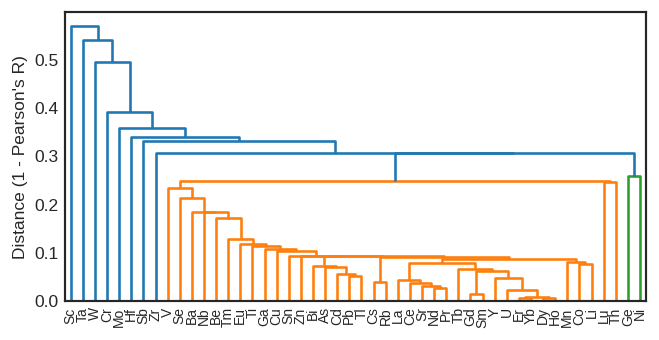

In [27]:
plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(6, 3), dpi=125)
dendrogram(linkage_matrix, labels=labels, color_threshold=.3, ax=ax)
ax.set_ylabel("Distance (1 - Pearson's R)")
plt.savefig('../output/figures/dendrogram.pdf', bbox_inches='tight')
plt.show()


If I set the threshold on a distance of 0.3 (or a Pearson correlation of < 0.7...) what we get is a huge group with many metals, a second cluster with `Ge` and `Ni` and several individual metals as sole leaves. 


In [28]:
big_metals_cluster = ['As', 'Ba', 'Be', 'Bi', 'Cd', 'Ce', 'Co', 'Cs', 'Cu', 'Dy', 'Er', 'Eu',
                      'Ga', 'Gd', 'Ho', 'La', 'Li', 'Lu', 'Mn', 'Nb', 'Nd', 'Pb', 'Pr', 'Rb', 'Se',
                      'Sm', 'Sn', 'Sr', 'Tb', 'Th', 'Ti', 'Tl', 'Tm', 'U', 'V', 'Y', 'Yb', 'Zn']

In [29]:
metals = wide_metals.columns
clusters = fcluster(linkage_matrix, 0.3, criterion='distance')
metal_clusters = {metal: cluster for metal, cluster in zip(metals, clusters)}
cluster_metals = defaultdict(list)
for cluster, metal in zip(clusters, metals):
    cluster_metals[cluster] += [metal]
    
for cluster, metals in cluster_metals.items():
    print(f'Cluster {cluster}:\n {metals}\n')

Cluster 1:
 ['As', 'Ba', 'Be', 'Bi', 'Cd', 'Ce', 'Co', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'Ga', 'Gd', 'Ho', 'La', 'Li', 'Lu', 'Mn', 'Nb', 'Nd', 'Pb', 'Pr', 'Rb', 'Se', 'Sm', 'Sn', 'Sr', 'Tb', 'Th', 'Ti', 'Tl', 'Tm', 'U', 'V', 'Y', 'Yb', 'Zn']

Cluster 7:
 ['Cr']

Cluster 2:
 ['Ge', 'Ni']

Cluster 5:
 ['Hf']

Cluster 6:
 ['Mo']

Cluster 4:
 ['Sb']

Cluster 10:
 ['Sc']

Cluster 9:
 ['Ta']

Cluster 8:
 ['W']

Cluster 3:
 ['Zr']



The aggregated variation in concentration of each clusters looks as follows:


In [ ]:
import string

In [31]:
def min_max_norm(x):
    return (x - min(x)) / (max(x) - min(x))

In [32]:
min_max_metals = (long_metals
 .groupby('compound')
 .apply(lambda dd: dd.assign(concentration=min_max_norm(dd.concentration)))
 .reset_index(drop=True)
  .assign(cluster=lambda dd: dd.compound.map(metal_clusters))
 .assign(metals=lambda d: d.cluster.map(cluster_metals))
 .assign(cluster_label=lambda dd: 'Cluster ' + dd.cluster.apply(lambda x: string.ascii_uppercase[x - 1]) + ': ' 
         + dd.metals.apply(lambda x: ', '.join(x) if x != big_metals_cluster else '38 metals'))

)

/home/afontal/.cache/pypoetry/virtualenvs/kd-metals-swc-La39c6PI-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/afontal/.cache/pypoetry/virtualenvs/kd-metals-swc-La39c6PI-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


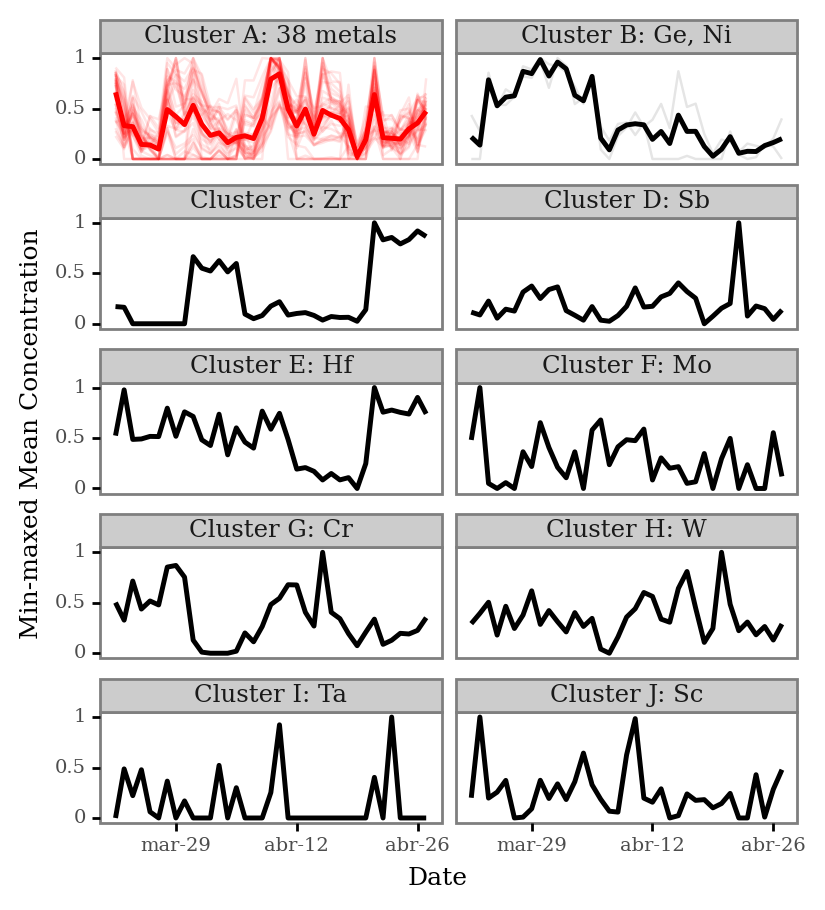

In [74]:
f = (min_max_metals
  .groupby(['cluster_label', 'date'])
 .concentration.mean()
 .reset_index()
  .pipe(lambda dd: p9.ggplot(dd) 
       + p9.aes('date', 'concentration', color='cluster_label=="Cluster A: 38 metals"') 
       + p9.geom_line(size=1)
       + p9.geom_line(data=min_max_metals, mapping=p9.aes(group='compound'), alpha=.1)
       
       + p9.facet_wrap('cluster_label', scales='fixed', ncol=2)
       + p9.scale_x_datetime(breaks=date_breaks('2 weeks'), labels=date_format('%b-%d'))
       + p9.scale_y_continuous(breaks=[0, .5, 1])
       + p9.scale_color_manual(['black', 'red'])
       + p9.theme(figure_size=(4.5, 5), panel_grid=p9.element_blank())
       + p9.labs(x='Date', y='Min-maxed Mean Concentration')
       + p9.guides(color=False)
      )
).draw()
f.savefig('../output/figures/clusters_ts.pdf', bbox_inches='tight')

And we can visualize the intra-cluster 1 variability in the following figure, with the shadowed lines representing the min-maxed concentration of each individual metal within the cluster, and the dark thick line representing the average value of all the metals in the claster at each sample:


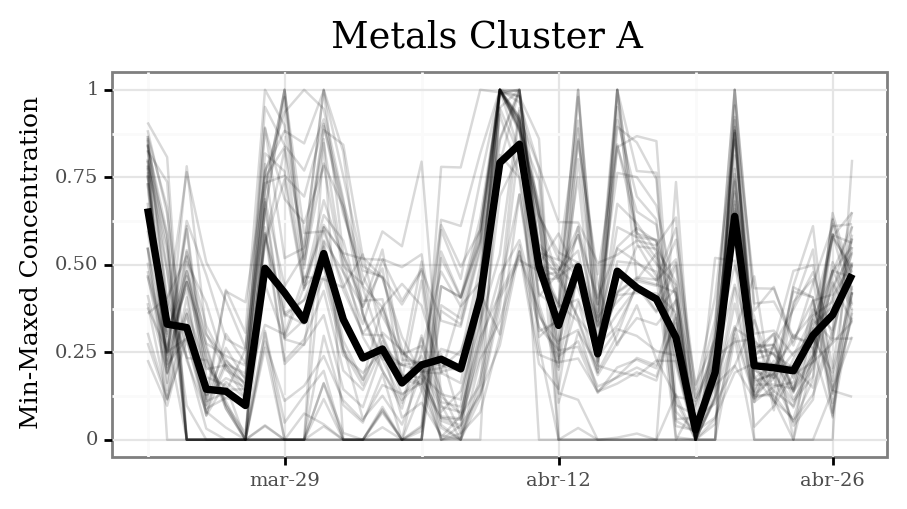

<ggplot: (8771550883434)>

In [34]:
(long_metals
 .assign(cluster=lambda dd: dd.compound.map(metal_clusters))
 .loc[lambda dd: dd.cluster==1]
 .groupby(['compound'])
 .apply(lambda dd: dd.assign(concentration=min_max_norm(dd.concentration)))
 .reset_index(drop=True)
 .pipe(lambda dd: p9.ggplot(dd)
       + p9.aes('date', 'concentration')
       + p9.geom_line(p9.aes(group='compound'), alpha=.15)
       + p9.stat_summary(fun_y=np.mean, geom='line', size=1.5)
       + p9.theme(figure_size=(5, 2.5))
       + p9.scale_x_datetime(breaks=date_breaks('2 weeks'), labels=date_format('%b-%d'))
       + p9.labs(x='', y='Min-Maxed Concentration', title='Metals Cluster A'))
)

/home/afontal/.cache/pypoetry/virtualenvs/kd-metals-swc-La39c6PI-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


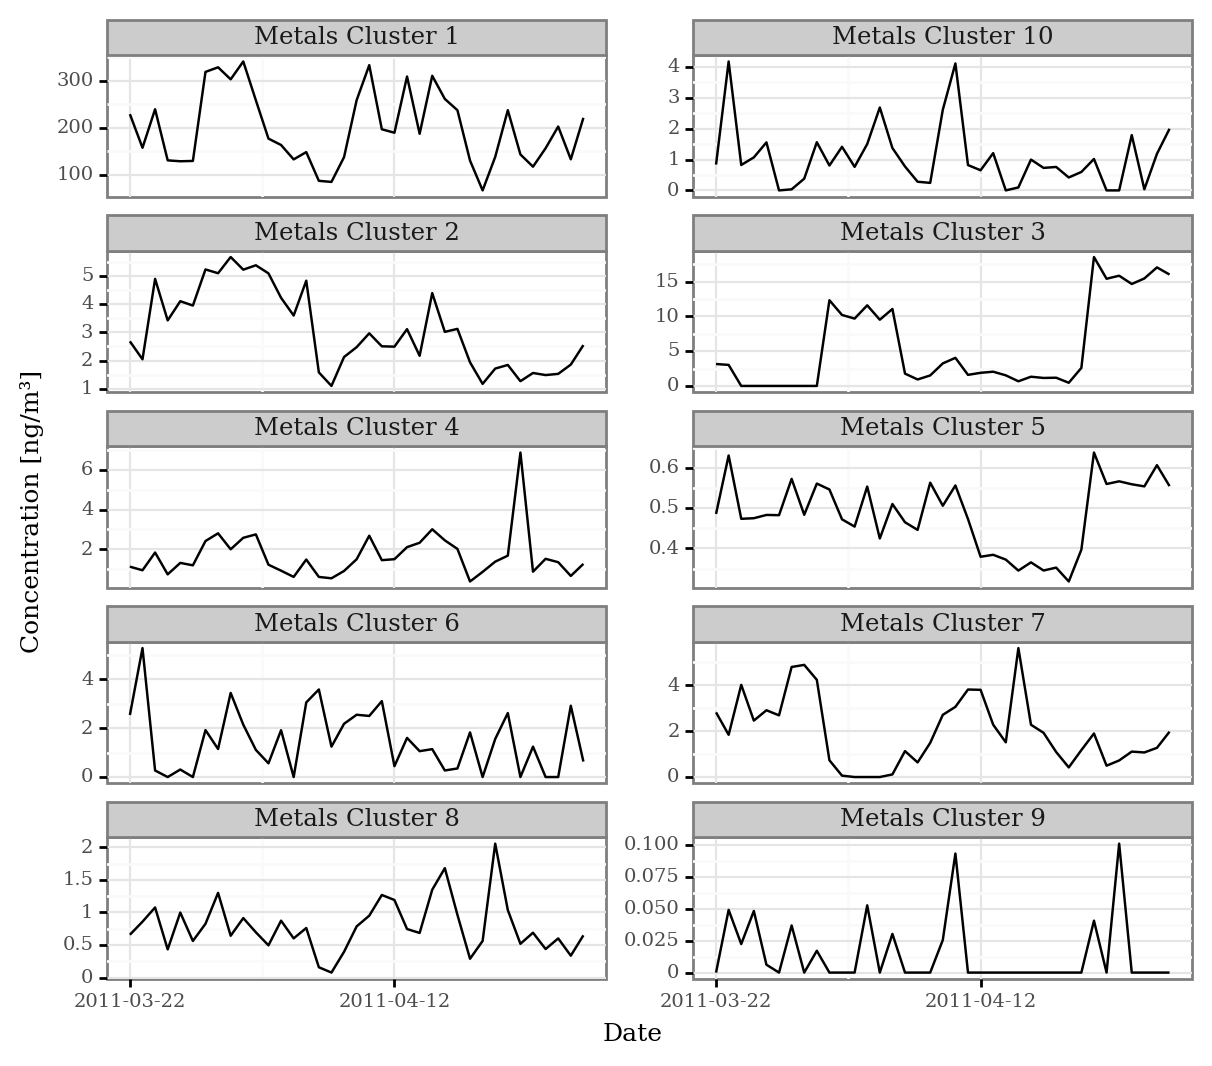

<ggplot: (8771537107737)>

In [37]:
cluster_concentrations = \
(long_metals
 .assign(cluster=lambda dd: dd.compound.map(metal_clusters))
 .groupby(['cluster', 'date'])
 .concentration.sum()
 .reset_index()
)
(cluster_concentrations
  .pipe(lambda dd: p9.ggplot(dd) 
       + p9.aes('date', 'concentration') 
       + p9.geom_line() 
       + p9.facet_wrap(['"Metals Cluster " + cluster.astype(str)'], scales='free_y', ncol=2)
       + p9.scale_x_datetime(breaks=date_breaks('3 weeks'))
       + p9.theme(figure_size=(7, 6), subplots_adjust={'wspace': 0.175})
       + p9.labs(x='Date', y='Concentration [ng/m³]')
      )
)

### Poisson Regression

In [40]:
poisson_regression_df = cluster_concentrations.query('cluster==1').merge(kd_ts)

In [41]:
poisson_model = smf.poisson('kd_rolling_4 ~ concentration', data=poisson_regression_df).fit()

Optimization terminated successfully.
         Current function value: 1.560838
         Iterations 5


In [42]:
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:           kd_rolling_4   No. Observations:                   37
Model:                        Poisson   Df Residuals:                       35
Method:                           MLE   Df Model:                            1
Date:                jue, 02 jun 2022   Pseudo R-squ.:                 0.09547
Time:                        15:39:54   Log-Likelihood:                -57.751
converged:                       True   LL-Null:                       -63.846
Covariance Type:            nonrobust   LLR p-value:                 0.0004802
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1577      0.328     -0.481      0.630      -0.800       0.485
concentration     0.0048      0.001      3.495      0.000       0.002       0.007
=================================================================================
"""

In [43]:
preds = poisson_model.predict()


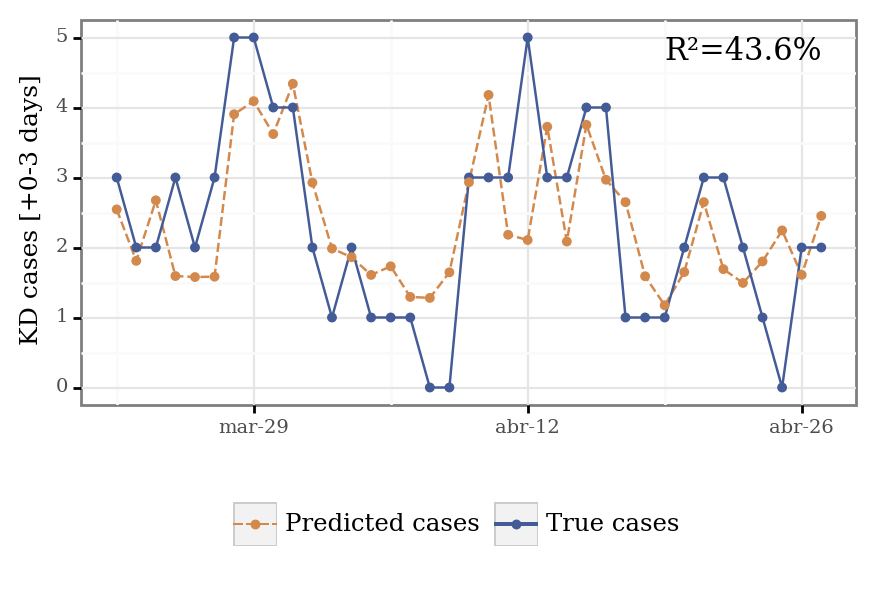

In [44]:
f = (kd_ts.assign(preds=preds)
 [['date', 'kd_rolling_4', 'preds']]
 .melt('date')
 .replace({'preds': 'Predicted cases',
           'kd_rolling_4': 'True cases'})
 .pipe(lambda dd: 
       p9.ggplot(dd)
       + p9.aes('date', 'value', color='Filter', linetype='Filter')
       + p9.geom_line()
       + p9.geom_point(size=1)
       + p9.scale_color_manual(['#D3894C', '#435B97'])
       + p9.scale_linetype_manual(['dashed', 'solid'])
       + p9.scale_x_datetime(breaks=date_breaks('2 weeks'), labels=date_format('%b-%d'))
       + p9.labs(x='', y='KD cases [+0-3 days]', color='', linetype='')
       + p9.annotate(x='2011-04-23', y=4.8, geom='text', label='R²=43.6%')
       + p9.theme(figure_size=(5, 2.5), legend_position='bottom',
                  legend_background= p9.element_blank())

)
).draw()
f.savefig('../output/figures/poisson_preds.pdf', bbox_inches='tight')

In [45]:
def poisson_predict(x, alpha, beta):
    return np.exp(alpha + x * beta)

In [46]:
double_axis_fig_data = (cluster_concentrations
 .loc[lambda dd: dd.cluster==1]
 .merge(kd_ts)
 [['date', 'concentration', 'kd_rolling_4']]
 .melt('date')
 .replace({'concentration': 'Aggregated Concentration of Cluster A metals [ng/m³]',
           'kd_rolling_4': 'KD cases +0-3 days'})
                       )

/home/afontal/.cache/pypoetry/virtualenvs/kd-metals-swc-La39c6PI-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


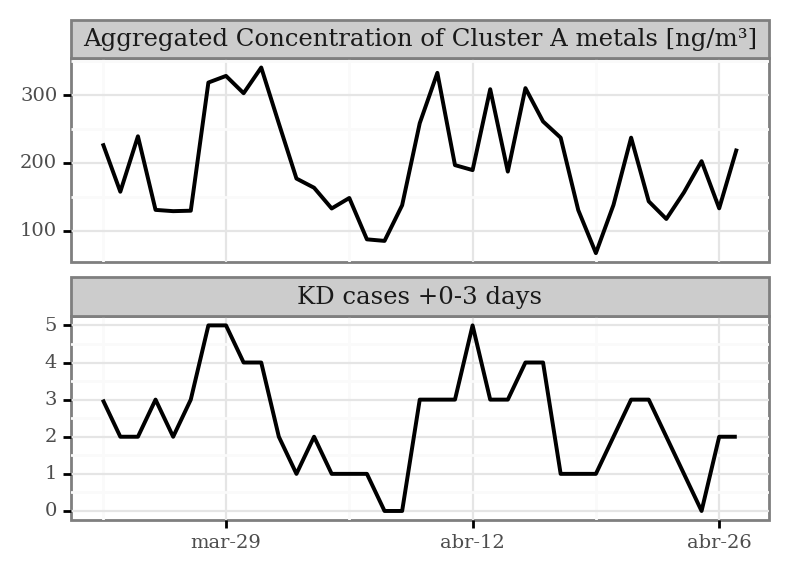

In [47]:
f = (double_axis_fig_data
  .pipe(lambda dd: p9.ggplot(dd) 
        + p9.aes('date', 'value') 
        + p9.geom_line(size=.8)
        + p9.facet_wrap('variable', scales='free_y', ncol=1)
        + p9.theme(figure_size=(4.5, 3))
        + p9.labs(x='', y='')
        + p9.scale_x_datetime(breaks=date_breaks('2 weeks'), labels=date_format('%b-%d'))
)
).draw()
f.savefig('../output/figures/kd_vs_cluster_ts.pdf', bbox_inches='tight')

In [48]:
double_axis_fig_data.groupby(['variable']).value.max()

variable
Aggregated Concentration of Cluster A metals [ng/m³]    340.933779
KD cases +0-3 days                                        5.000000
Name: value, dtype: float64

In [49]:
double_axis_fig_data = (double_axis_fig_data
 .replace({'Aggregated Concentration of Cluster A metals [ng/m³]': 'cluster_a',
           'KD cases +0-3 days': 'kd_cases'})
 .pivot('date', 'variable', 'value')        
 
)

In [50]:
double_axis_fig_data = double_axis_fig_data.reset_index()

/home/afontal/.cache/pypoetry/virtualenvs/kd-metals-swc-La39c6PI-py3.8/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2211: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
R[write to console]: Saving 4.33 x 2.33 in image



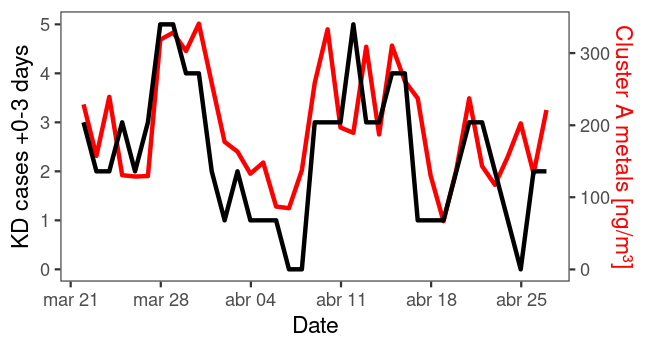

In [51]:
%%R -i double_axis_fig_data -w 650 -h 350 -r 150

coef <- 340 / 5 + .005

f <- ggplot(double_axis_fig_data) + 
    aes(date, kd_cases) +
    theme_bw() +
    labs(x='Date') +
    scale_y_continuous(name='KD cases +0-3 days',
                       sec.axis=sec_axis(trans=~.*coef, name='Cluster A metals [ng/m³]')) + 
    geom_line(aes(y=cluster_a / coef), color='red', alpha=1, size=1) +
    geom_line(size=1) +
    theme(axis.title.y.right = element_text(color = 'red', size=11),
          axis.title.y.left = element_text(size=11),
          panel.grid=element_blank()) 
ggsave('../output/figures/metals_kd_shared.pdf', f, device=cairo_pdf)
f

##### Bootstrapped CI

In [ ]:
coef_estimates = dict(alpha=[], beta=[])
for _ in range(1000):
    boot_df = poisson_regression_df.sample(19)
    poisson= smf.poisson('kd_rolling_4 ~ concentration', data=boot_df).fit()
    a, b = poisson.params
    coef_estimates['alpha'].append(a)
    coef_estimates['beta'].append(b)

In [53]:
estimates_df = pd.DataFrame(coef_estimates)

/home/afontal/.cache/pypoetry/virtualenvs/kd-metals-swc-La39c6PI-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


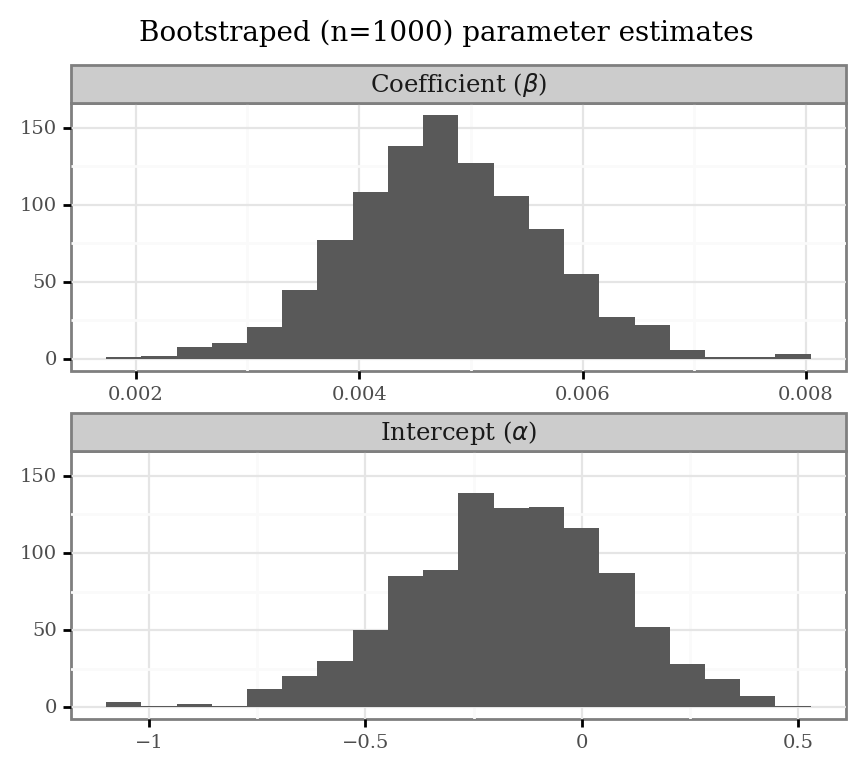

<ggplot: (8771536602332)>

In [54]:
(estimates_df
 .melt()
 .replace({'alpha': r'Intercept ($\alpha$)', 'beta': r'Coefficient ($\beta$)'})
 .pipe(lambda dd: p9.ggplot(dd) + p9.aes('value') 
       + p9.facet_wrap('variable', ncol=1, scales='free_x')
       + p9.geom_histogram(bins=20)
       + p9.theme(subplots_adjust={'hspace': 0.3},
                  figure_size=(5, 4),
                  title=p9.element_text(size=10))
       + p9.labs(x='', y='', title='Bootstraped (n=1000) parameter estimates')
    )
)

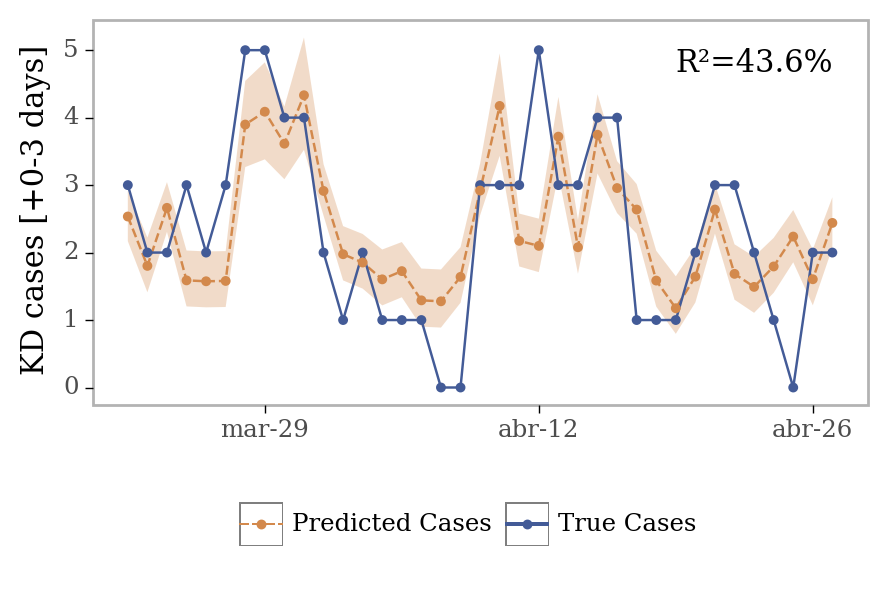

In [55]:
(cluster_concentrations
 .loc[lambda dd: dd.cluster==1]
 .merge(kd_ts, on='date')
 .assign(boot_preds=lambda dd: dd.concentration.apply(lambda x:
    [poisson_predict(x, alpha, beta) 
     for alpha, beta
     in zip(estimates_df.alpha, estimates_df.beta)]
                                                     ))
 .assign(pred=lambda dd: dd['boot_preds'].apply(lambda x: np.median(x)))
 .assign(lo_pred=lambda dd: dd['boot_preds'].apply(lambda x: np.quantile(x, .025)))
 .assign(hi_pred=lambda dd: dd['boot_preds'].apply(lambda x: np.quantile(x, .975)))
 .pipe(lambda dd: 
       p9.ggplot(dd[['date', 'kd_rolling_4', 'pred']]
                 .melt('date')
                 .replace({'kd_rolling_4': 'True Cases',
                           'pred': 'Predicted Cases'}))
       + p9.aes('date', 'value', color='variable', linetype='variable')
       + p9.geom_ribbon(p9.aes(x='date', ymin='lo_pred', ymax='hi_pred'),
                        fill='#D3894C', alpha=.3, data=dd, inherit_aes=False)
       + p9.geom_line()
       + p9.geom_point(size=1)
       + p9.theme_light()
       + p9.theme(figure_size=(5, 2.5), legend_position='bottom',
                  legend_background=p9.element_blank(),
                  panel_grid=p9.element_blank())
       + p9.scale_color_manual(['#D3894C', '#435B97', 'black'])
       + p9.scale_linetype_manual(['dashed', 'solid', 'dashed'])
       + p9.scale_x_datetime(breaks=date_breaks('2 weeks'), labels=date_format('%b-%d'))
       + p9.labs(x='', y='KD cases [+0-3 days]', color='', linetype='')
       + p9.annotate(x='2011-04-23', y=4.8, geom='text', label='R²=43.6%')
)).draw().savefig('../output/figures/clean_preds.pdf', bbox_inches='tight')

#### Treating concentration as a categorical variable

Given the non-linearities we would expect on the effect of metals dose and likelihood of triggering the autoimmune response in vasculitis, it might be worth considering concentration as discrete categories. Let's take an initial look at how it would look:

##### With 3 categories


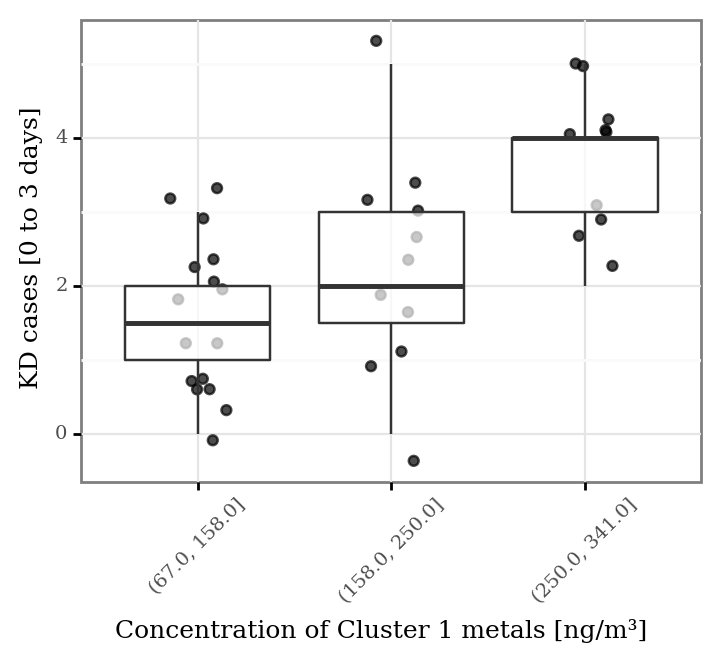

<ggplot: (8764396104578)>

In [85]:
(cluster_concentrations
 .loc[lambda dd: dd.cluster==1]
 .merge(kd_ts)
 .assign(cat_concentration=lambda dd: pd.cut(dd.concentration, 3, precision=0))
  .pipe(lambda dd: p9.ggplot(dd) 
        + p9.aes('cat_concentration', 'kd_rolling_4') 
        + p9.geom_jitter(alpha=.7, width=.15)
        + p9.geom_boxplot(alpha=.7)
        + p9.labs(x='Concentration of Cluster 1 metals [ng/m³]', y='KD cases [0 to 3 days]')
        + p9.theme(figure_size=(4, 3), axis_text_x=p9.element_text(rotation=45))
       )

)

In [58]:
(cluster_concentrations
 .loc[lambda dd: dd.cluster==1]
 .merge(kd_ts)
 .assign(cat_concentration=lambda dd: pd.cut(dd.concentration, 3, precision=0))
 .pipe(lambda dd: smf.ols('kd_rolling_4 ~ cat_concentration', data=dd).fit().summary())
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           kd_rolling_4   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     11.93
Date:                jue, 02 jun 2022   Prob (F-statistic):           0.000119
Time:                        15:44:38   Log-Likelihood:                -54.044
No. Observations:                  37   AIC:                             114.1
Df Residuals:                      34   BIC:                             118.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       1.5625      0.272      5.746      0.000       1.010       2.115
cat_concentration[T.Interval(158.0, 250.0, closed='right')]     0.7102      0.426      1.667      0.105      -0.155       1.576
cat_concentration[T.Interval(250.0, 341.0, closed='right')]     2.1375      0.438      4.875      0.000       1.246       3.029
==============================================================================
Omnibus:                        0.271   Durbin-Watson:                   1.265
Prob(Omnibus):                  0.873   Jarque-Bera (JB):                0.096
Skew:                           0.121   Prob(JB):                        0.953
Kurtosis:                       2.944   Cond. No.                         3.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
(cluster_concentrations
 .loc[lambda dd: dd.cluster==1]
 .merge(kd_ts)
 .assign(cat_concentration=lambda dd: pd.cut(dd.concentration, 3, precision=0))
 .pipe(lambda dd: pairwise_tukeyhsd(endog=dd['kd_rolling_4'],
                                    groups=dd['cat_concentration'],
                                    alpha=.05))
 .summary()
)

group1,group2,meandiff,p-adj,lower,upper,reject
"(67.0, 158.0]","(158.0, 250.0]",0.7102,0.2323,-0.3336,1.7541,False
"(67.0, 158.0]","(250.0, 341.0]",2.1375,0.0001,1.0631,3.2119,True
"(158.0, 250.0]","(250.0, 341.0]",1.4273,0.0135,0.2628,2.5918,True


#### Test for 3 categories

In [67]:
cluster_bins = (cluster_concentrations
 .loc[lambda dd: dd.cluster==1]
 .merge(kd_ts)
 .assign(cat_concentration=lambda dd: pd.cut(dd.concentration, 3, precision=0,
                                             labels=['Low', 'Medium', 'High']))
)

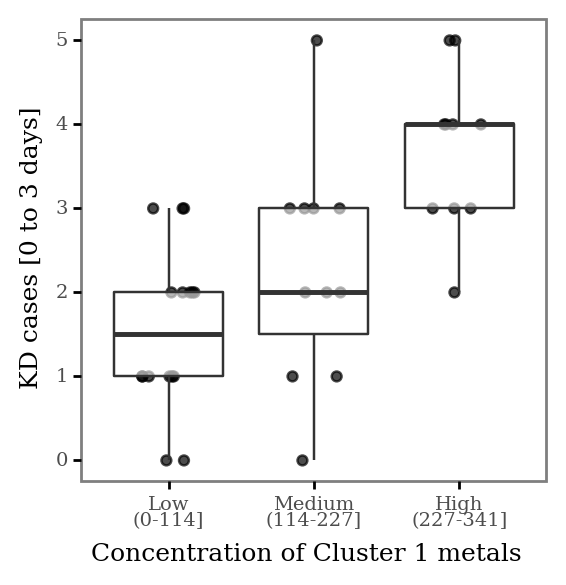

In [63]:
(cluster_bins
 .assign(cat_concentration=lambda dd: pd.cut(dd.concentration, 3, precision=0,
                                             labels=['Low\n(0-114]', 'Medium\n(114-227]', 'High\n(227-341]']))
  .pipe(lambda dd: p9.ggplot(dd) 
        + p9.aes('cat_concentration', 'kd_rolling_4') 
        + p9.geom_jitter(alpha=.7, width=.2, height=0)
        + p9.geom_boxplot(alpha=.6)
        + p9.labs(x='Concentration of Cluster 1 metals', y='KD cases [0 to 3 days]')
        + p9.theme(figure_size=(3, 3), axis_title=p9.element_text(size=9), panel_grid=p9.element_blank())
       ).draw().savefig('../output/figures/boxplots.pdf')

)

In [69]:
comp_lo_med_hi = dabest.load(cluster_bins,
                             x='cat_concentration',
                             y='kd_rolling_4',
                             idx=['Low', 'Medium', 'High'])

/home/afontal/.cache/pypoetry/virtualenvs/kd-metals-swc-La39c6PI-py3.8/lib/python3.8/site-packages/dabest/_classes.py:158: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
/home/afontal/.cache/pypoetry/virtualenvs/kd-metals-swc-La39c6PI-py3.8/lib/python3.8/site-packages/dabest/_classes.py:159: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.


In [70]:
bootstrap_test_results = (comp_lo_med_hi
                         .mean_diff
                         .results
                         .append(comp_med_hi.mean_diff.results)
                         
)

/tmp/ipykernel_187664/4183274719.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [71]:
(bootstrap_test_results
   .iloc[[0, 2, 1]]
 .explode('bootstraps')
 .assign(test_label=lambda dd: dd.test + ' - ' + dd.control)
 [['test_label', 'difference', 'bootstraps', 'pvalue_permutation']]
 .drop(columns='bootstraps')
 .drop_duplicates()
)

,test_label,difference,pvalue_permutation
0,Medium - Low,0.710227,0.0940
0,High - Medium,1.427273,0.0124
1,High - Low,2.137500,0.0000


In [72]:
a = '#EEA236'
b = '#A94442'
c = '#5CB85C'

/home/afontal/.cache/pypoetry/virtualenvs/kd-metals-swc-La39c6PI-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/afontal/.cache/pypoetry/virtualenvs/kd-metals-swc-La39c6PI-py3.8/lib/python3.8/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/afontal/.cache/pypoetry/virtualenvs/kd-metals-swc-La39c6PI-py3.8/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


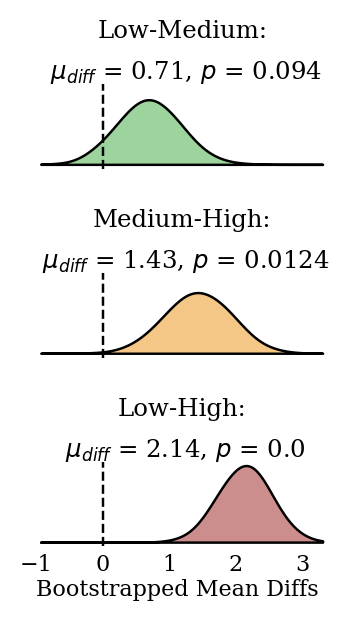

In [73]:
(bootstrap_test_results
 .iloc[[0, 2, 1]]
 .explode('bootstraps')
 .assign(test_label=lambda dd: dd.control + '-' + dd.test)
 .assign(bootstraps=lambda dd: dd.bootstraps.astype(float))
 [['test_label', 'difference', 'bootstraps', 'pvalue_permutation']]
 .assign(label=lambda dd: 
         dd.test_label +  ':\n $\mu_{diff}$ = ' + dd.difference.round(2).astype(str)
         + ', $p$ = ' + dd.pvalue_permutation.astype(str))
 .assign(label=lambda dd: pd.Categorical(dd.label, categories=dd.label.unique(), ordered=True))
 .pipe(lambda dd: p9.ggplot(dd)
       + p9.aes('bootstraps', fill='test_label')
       + p9.geom_density(bw=.2, alpha=.6)
       + p9.facet_wrap('label', ncol=1)
       + p9.labs(x='Bootstrapped Mean Diffs', y='')
       + p9.theme_void()
       + p9.theme(figure_size=(2, 3),
                  axis_text_x=p9.element_text(va='top', size=8),
                  axis_title_x=p9.element_text(size=8))
       + p9.scale_fill_manual([b, c, a])
       + p9.geom_vline(xintercept=0, linetype='dashed')
       + p9.guides(fill=False)
      ).draw().savefig('../output/figures/bs.pdf')
 )